# Logistic Regression


**Input** 

- n : the number of data point
- $mx_1$, $vx_1$, $my_1$, $vy_1$, $mx_2$, $vx_2$, $my_2$, $vy_2$

In [237]:

## a. Univariate Gaussian data generator
# - mean: $m$
# - Variance: $s$
# - handcraft gaussian distribution
#     - **Box-Muller transform**
#     - Ziggurat algorithm
# - np.random.uniform()

import numpy as np

def  univariate_Gaussian_data_generator(m,s):
    u1 = np.random.uniform(0,1)
    u2 = np.random.uniform(0,1)
    z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    x = m + np.sqrt(s) * z
    return x


#print(univariate_Gaussian_data_generator(1.2204925277612,0))

# point = [ ma, va, mb, vb, mc, vc, md, vd]


def generate_data_point(n, point):

    d1x = [univariate_Gaussian_data_generator(point[0], point[4]) for _ in range(n)] #n(mx1,vx1)
    d1y = [univariate_Gaussian_data_generator(point[1], point[5]) for _ in range(n)] #n(my1,vy1)
    d2x = [univariate_Gaussian_data_generator(point[2], point[6]) for _ in range(n)]
    d2y = [univariate_Gaussian_data_generator(point[3], point[7]) for _ in range(n)]

    print(len(d1x))

    D1 = np.array([d1x, d1y]).T
    D2 = np.array([d2x, d2y]).T

    return D1, D2

def prepare_dataset(D1, D2):
    X = np.vstack((D1, D2))
    y = np.array([0] * len(D1) + [1] * len(D2)).reshape(-1, 1)

    return X, y



In [238]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_hessian(X, w):
    h = sigmoid(X @ w)
    S = np.diag((h * (1 - h)).flatten())
    return X.T @ S @ X

def add_bias(X):
    # 在最前面加一列常數 1
    return np.hstack([np.ones((X.shape[0], 1)), X])


def logistic_regression_newtonmethod(X, y, max_iter=1000, tol=1e-6, lr=0.01):
    n_samples, n_features = X.shape
    w = np.random.rand(n_features, 1)

    for i in range(max_iter):
        z = X @ w
        h = sigmoid(z)
        grad = X.T @ (y - h)
        H = compute_hessian(X, w)

        try:
            H_inv = np.linalg.inv(H)
        except np.linalg.LinAlgError:
            print("Hessian is singular. Using pseudo-inverse instead.")
            H_inv = np.linalg.pinv(H)

        update = lr * (H_inv @ grad)
        w += update

        if np.linalg.norm(update) < tol:
            print(f"Converged in {i+1} iterations.")
            break

    return w




def logistic_regression_gradientdescent(X, y, max_iter=10000, tol=1e-6, lr=0.01):

    n_samples, n_features = X.shape
    w = np.random.rand(n_features, 1)

    for t in range(max_iter):
        grad = X.T @ (y - sigmoid(X @ w))
        w += lr * grad


        if np.linalg.norm(grad) < tol:
            print(f"Converged in {t+1} iterations.")
            break


    return w



def predict(X, w):

    return (sigmoid(X@w) >= 0.5).astype(int)


def confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    return TP, TN, FP, FN


def evaluate(y_true, y_pred):
    TP, TN, FP, FN = confusion_matrix(y_true, y_pred)
    sensitivity = TP / (TP+FN) # 所有positive中模型預測正確比率
    specificity = TN / (TN+FP) # 所有negative中模型預測正確比率
    accuracy =  (TP+TN)/(TP + TN + FP + FN)

    matrix = f"""
Confusion Matrix:
                 Predict cluster 1   Predict cluster 2
Is cluster 1         {TN:<10}           {FP:<10}
Is cluster 2         {FN:<10}           {TP:<10}

Sensitivity (Successfully predict cluster 2): {sensitivity:.5f}
Specificity (Successfully predict cluster 1): {specificity:.5f}
Accuracy : {accuracy * 100:.2f}%
"""
    print(matrix)


#D1, D2  = generate_data_point(50, [1,1,10,10,2,2,2,2])
D1, D2  = generate_data_point(50, [1,1,3,3,2,2,4,4])
X, y = prepare_dataset(D1, D2)
X = add_bias(X)  # 加 bias 項

print(X.shape, y.shape)

w_gd = logistic_regression_gradientdescent(X, y, max_iter=1000, tol=0.01, lr=0.01)

print(w_gd)


y_pred_gd = predict(X, w_gd)
evaluate(y_pred_gd.flatten(), y.flatten())

w_n = logistic_regression_newtonmethod(X, y, max_iter=1000, tol=0.01, lr=0.01)

print(w_n)

y_pred_n = predict(X, w_n)
evaluate(y_pred_n.flatten(), y.flatten())




50
(100, 3) (100, 1)
Converged in 329 iterations.
[[-3.39227621]
 [ 0.97134353]
 [ 0.70518913]]

Confusion Matrix:
                 Predict cluster 1   Predict cluster 2
Is cluster 1         41                   10        
Is cluster 2         9                    40        

Sensitivity (Successfully predict cluster 2): 0.81633
Specificity (Successfully predict cluster 1): 0.80392
Accuracy : 81.00%

Converged in 175 iterations.
[[-2.08126222]
 [ 0.66995034]
 [ 0.4827342 ]]

Confusion Matrix:
                 Predict cluster 1   Predict cluster 2
Is cluster 1         37                   9         
Is cluster 2         13                   41        

Sensitivity (Successfully predict cluster 2): 0.75926
Specificity (Successfully predict cluster 1): 0.80435
Accuracy : 78.00%



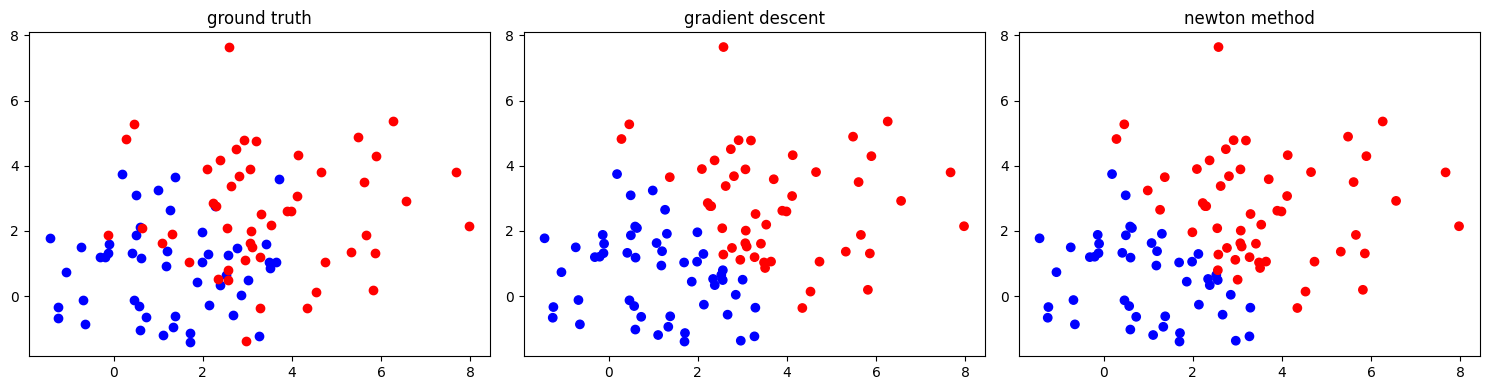

In [239]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 建立1x3子圖

axs[0].scatter(D1[:, 0], D1[:, 1], c='blue', label='Cluster 1')
axs[0].scatter(D2[:, 0], D2[:, 1], c='red', label='Cluster 2')
axs[0].set_title("ground truth")

axs[1].scatter(X[:, 1], X[:, 2], c=y_pred_gd, cmap='bwr')
axs[1].set_title("gradient descent")

axs[2].scatter(X[:, 1], X[:, 2], c=y_pred_n, cmap='bwr')
axs[2].set_title("newton method")

plt.tight_layout()
plt.show()


# EM algorithm